# Water detection with Sentinel-1 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc)

## Background

Over 40% of the world’s population lives within 100 km of the coastline.
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats.
Updating data on the position of the coastline is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion. 
The coastal regions are also home to many wetlands. Monitoring of water extent helps to understand and protect these dynamic and productive ecosystems.

While coastlines and water extents can be mapped using optical data (demonstrated in the [Coastal Erosion notebook](../Real_world_examples/Coastal_erosion.ipynb)), these images can be strongly affected by the weather, especially through the presence of clouds, which obscure the land and water below.
This can be a particular problem in cloudy regions or areas where clouds in wet season prevent optical satellites from taking clear images for many months of the year.

Radar observations are largely unaffected by cloud cover.
The two Sentinel-1 satellites, operated by ESA as part of the Copernicus program, provide all-weather observations every 6 to 12 days over Africa.
By developing a process to classify the observed pixels as either water or land, it is possible to identify the shoreline and map the dynamic water extents using radar data.
For more information, see the [Sentinel-1](../Datasets/Sentinel_1.ipynb) notebook.

## Description

In this example, we use data from the Sentinel-1 satellites to build a classifier that can determine whether a pixel is a water or land.
Specifically, this notebook uses analysis-ready radar backscatter, which describes the strength of the signal received by the satellite.

The notebook contains the following steps:

1. Load Sentinel-1 backscatter data for an area of interest and visualize the returned data
2. Applying speckle filter and converting the digital numbers to dB values for analysis
3. Use histogram analysis to determine the threshold for water classification
4. Design a classifier to distinguish land and water
5. Apply the classifier to the area of interest and interpret the results

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import warnings 
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Radar_water_detection")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2020') `)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the coast of Ziguinchor, Gambia.


### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
# Define the area of interest
lat = 12.62 
lon = -16.29  
buffer = 0.05

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

#timeframe
timerange = ('2020')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest. This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. 

**Please be patient**.
The data may take a few minutes to load and progress will be indicated by text output.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [5]:
# Load the Sentinel-1 data
S1 = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              y=lat_range,
              x=lon_range,
              time=timerange,
              output_crs = "EPSG:6933",
              resolution = (-20,20),
              group_by="solar_day",
              dtype='native'
             )

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 31 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument reveals the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
print(S1)

<xarray.Dataset>
Dimensions:      (time: 31, y: 623, x: 484)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:17:46.582116 ... 2020-12...
  * y            (y) float64 1.604e+06 1.604e+06 ... 1.591e+06 1.591e+06
  * x            (x) float64 -1.577e+06 -1.577e+06 ... -1.567e+06 -1.567e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.05976 0.04359 0.02704 ... 0.1871 0.1521
    vh           (time, y, x) float32 0.005369 0.004237 ... 0.01575 0.01733
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Visualize the time series

Coastal and wetlands are highly dynamic, so cloud-free assessment using radar is valuable to capture change in all seasons. In the next few cells, Sentinel-1 observations in different polarisations are plotted for selected dates. Noting VV backscatter is usually significantly higher than VH. Signals from the two polarizations are dominated by different scattering mechanisms therefore respond differently to surface characeristics. 

Both polarizations show siginficant surface cover change over time. Open water is characterized by low backscatter due to specular reflection. Water area with standing vegetation leads to high backscatter and will not be mapped using the thresholding method below. This may result in differenct water extent measurement compared to methods using optical data.

In [7]:
#Selecting a few images from the loaded S1 to visualise 
timesteps = [2,4,6,9,11]

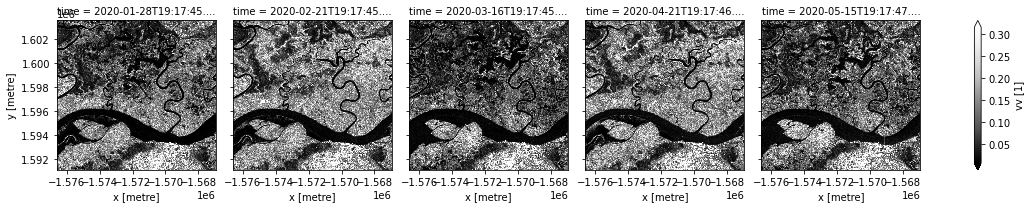

In [8]:
# Plot VV polarisation for specific timeframe 
S1.vv.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

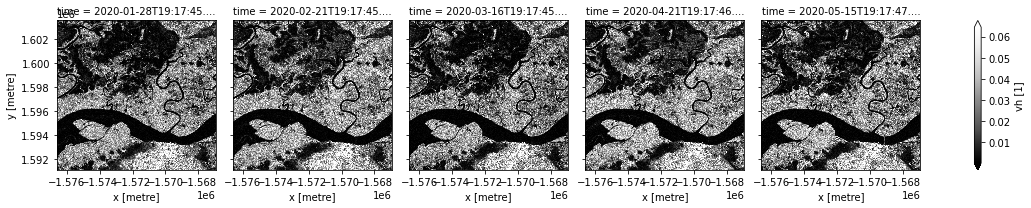

In [9]:
# Plot VH polarisation for specific timeframe 
S1.vh.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

Backscatter measurements can be combined in visualization to highlight the different polarization signatures. 
For the RGB visualization below, the ratio between VH and VV is added as a third measurement band.

In [10]:
# VH/VV is a potentially useful third feature after VV and VH 
S1['vh/vv'] = S1.vh/S1.vv

In [11]:
# median values are used to scale the measurements so they have a similar range for visualization
med_s1 = S1[['vv','vh','vh/vv']].median()

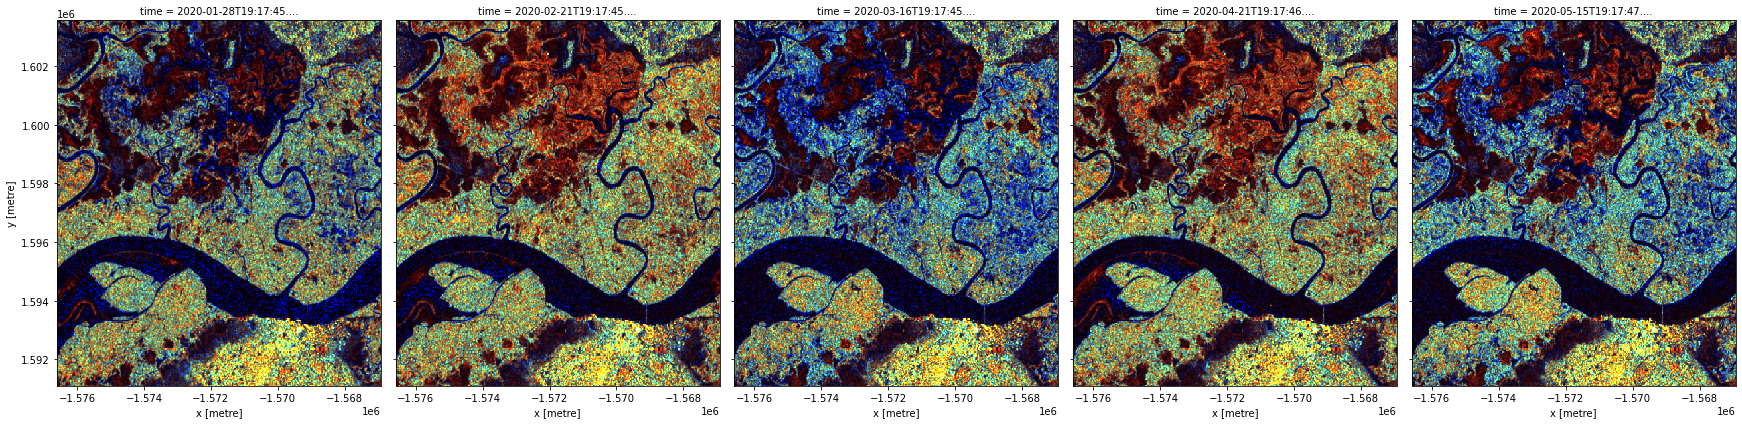

In [12]:
# plotting an RGB image for selected timesteps
rgb(S1[['vv', 'vh', 'vh/vv']]/med_s1, bands=['vv',
    'vh', 'vh/vv'], index=timesteps, col_wrap=5);

Significant changes in color pattern are visible from month to month. 
Open water and smooth bare surface appear dark blue because all measurements are low. 
Tree cover appears cyan because of the relatively higher VH signal from volume scattering. 
Areas in bright red are likely water with standing vegetation.
Urban area is shown in bright yellow at the bottom of the images.

## Apply speckle filtering

Radar observations appear speckly due to random interference of coherent signals from target scatters. 
The speckle noise can be reduced by averaging pixel values over an area or over time. 
However, averaging over a fixed window smoothes out real local spatial variation and leads to reduced spatial resolution.
An adaptive approach that takes into account local homogeneity is therefore preferred.

Below, we apply the Lee filter, one of the popular adaptive speckle filters.


In [13]:
#defining a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

Now that we've defined the filter, we can run it on the VV and VH data. You might have noticed that the function takes a size argument. This will change how blurred the image becomes after smoothing. We've picked a default value for this analysis, but you can experiement with this if you're interested.

In [14]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = xr.ufuncs.isfinite(S1)
S1 = S1.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
S1["filtered_vv"] = S1.vv.groupby("time").apply(lee_filter, size=7)
S1["filtered_vh"] = S1.vh.groupby("time").apply(lee_filter, size=7)

# Null pixels should remain null
S1['filtered_vv'] = S1.filtered_vv.where(valid.vv)
S1['filtered_vh'] = S1.filtered_vh.where(valid.vh)

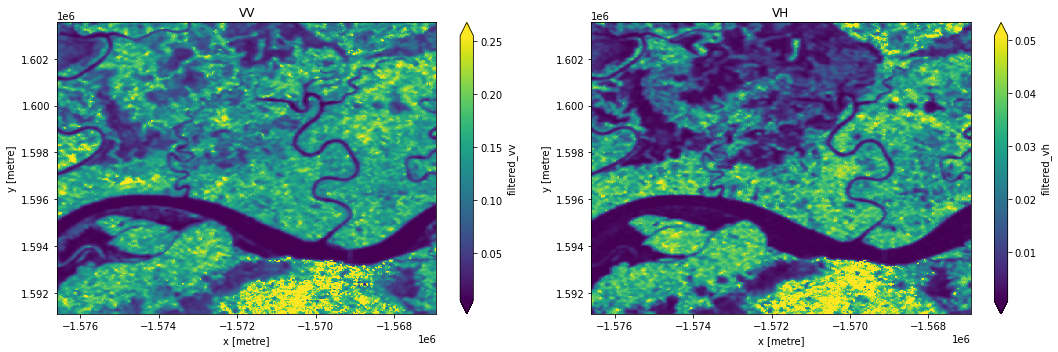

In [15]:
# images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15,5))
S1["filtered_vv"].isel(time=3).plot(ax = ax[0],robust=True)
S1["filtered_vh"].isel(time=3).plot(ax = ax[1],robust=True);
ax[0].set_title('VV')
ax[1].set_title('VH')
plt.tight_layout();

### Convert the digital numbers to dB

While Sentinel-1 backscatter is provided as linear intensiy, it is often useful to convert the backscatter to decible (dB) for analysis. 
Backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

In [16]:
S1['filtered_vv'] = 10 * xr.ufuncs.log10(S1.filtered_vv)
S1['filtered_vh'] = 10 * xr.ufuncs.log10(S1.filtered_vh)

## Histogram analysis for Sentinel-1

Backscatter distributions are plotted below as histograms.

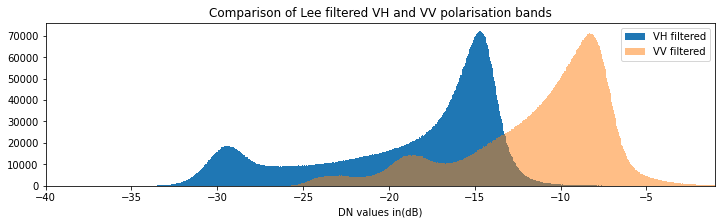

In [17]:
fig = plt.figure(figsize=(12, 3))
S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
S1.filtered_vv.plot.hist(bins=1000, label="VV filtered",alpha=0.5)
plt.xlim(-40,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Comparison of Lee filtered VH and VV polarisation bands");

## Build and apply the classifier 

The histogram for VH backscatter shows a bimodal distribution with low values over water and high values over land.
The VV histogram has multiple peaks and less obvious seperation between water and land.

We therefore build a classifier based on VH backscatter. We choose a threshold to separate land and water: pixels with values below the threshold are water, and pixels with values above the threshold are not water (land).

There are several ways to determine the threshold. 
Here, we use the `threshod_minimum` function implemented in the `skimage` package to determine the threshold from the *VH* histogram automatically.
This method computes the histogram for all backscatter values, smooths it until there are only two maxima and find the minimum in between as the threshold.

In [18]:
threshold_vh = threshold_minimum(S1.filtered_vh.values)

print(threshold_vh)

-25.55215


### Visualise threshold

To check if our chosen threshold reasonably divides the two distributions, we can add the threshold to the histogram plots we made earlier. 

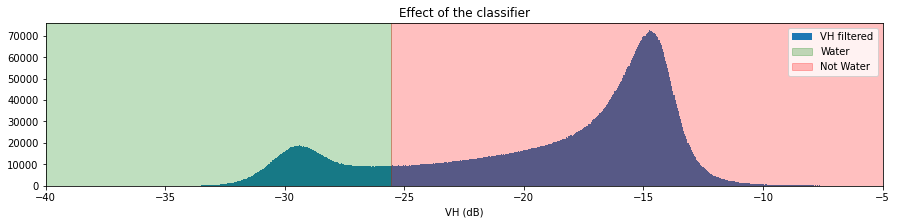

In [19]:
fig, ax = plt.subplots(figsize=(15, 3))
S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
plt.xlim(-40,-5)
ax.axvspan(xmin=-40.0, xmax=threshold_vh, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold_vh,
           xmax=-5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

### Define the classifier

This threshold is used to write a function to only return the pixels that are classified as water. The basic steps that the function will perform are:

1. Find all pixels that have filtered values lower than the threshold; these are the `water` pixels.
2. Return a data set containing the `water` pixels.


In [20]:
def S1_water_classifier(da, threshold=threshold_vh):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

Now that we have defined the classifier function, we can apply it to the data. After running the classifier, we will able to view the classified data product by running `print(S1.water)`.

In [21]:
S1['water'] = S1_water_classifier(S1.filtered_vh).s1_water

### Assessment with mean

We can now view the image with our classification.
The classifier returns either `True` or `False` for each pixel.
To detect the boundaries of water features, we want to check which pixels are always water and which are always land.
Conveniently, Python encodes `True = 1` and `False = 0`.

If we plot the average classified pixel value, pixels that are always water will have an average value of `1` and pixels that are always land will have an average of `0`.
Pixels that are sometimes water and sometimes land will have an average between these values. In this case study, these pixels are associated with seasonally inundated wetland areas. 

The following cell plots the average classified pixel value, or the frequency of water detection, over time.

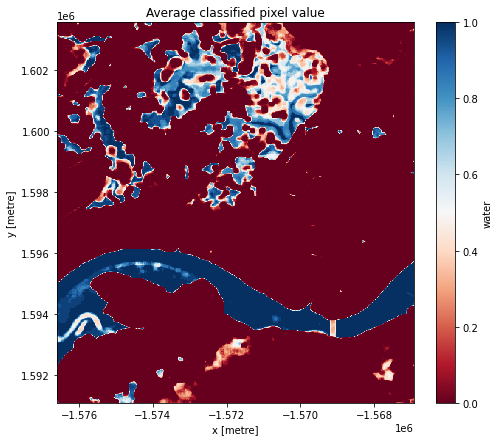

In [22]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(8, 7))
S1.water.mean(dim='time').plot(cmap="RdBu")
plt.title("Average classified pixel value");

You can see that the selected threshold has done a good job of separating the water pixels (in blue) and land pixels (in red) as well as ephemeral water features in between. 

You should be able to see that the shoreline takes on a mix of values between `0` and `1`, highlighting pixels that are sometimes land and sometimes water.
This is likely due to the effect of rising and falling tides, with some radar observations being captured at low tide, and others at high tide.



### Assessment with standard deviation

Given that we've identified the shoreline as the pixels that are classified sometimes as land and sometimes as water, we can also see if the standard deviation of each pixel over time is a reasonable way to determine if a pixel is a shoreline or not.

Similar to how we calculated and plotted the mean above, you can calculate and plot the standard deviation by using the `std` function in place of the `mean` function.

If you'd like to see the results using a different colour scheme, you can also try substituting `cmap="Greys"` or `cmap="Blues"` in place of `cmap="viridis"`.


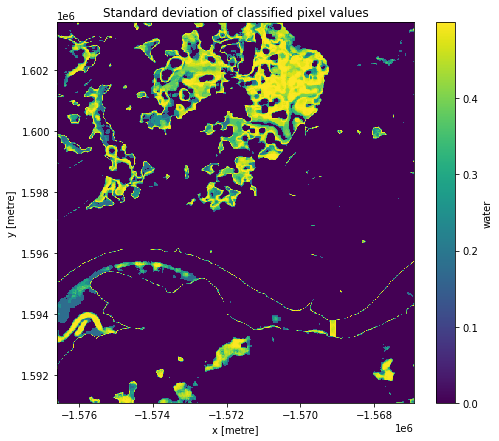

In [23]:
plt.figure(figsize=(8, 7))
S1.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values");

The standard deviation we calculated above gives us an idea of how variable a pixel has been over the entire period of time that we looked at. From the image above, you should be able to see that the land and water pixels almost always have a standard deviation of `0`, meaning they didn't change over the time we sampled. The shoreline and wetlands however have a higher standard deviation, indicating that they change frequently between water and non-water.

An important thing to recognise is that the standard deviation might not be able to detect the difference between noise, tides, and ongoing change, since a pixel that frequently alternates between land and water (noise) could have the same standard deviation as a pixel that is land for some time, then becomes water for the remaining time (ongoing change or tides).

## Next steps

When you are done, return to the "Analysis parameters" section, modify some values (e.g. lat and lon) and rerun the analysis. You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for. You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [24]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [25]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-10-27'